

# **VGG16**



In [2]:
!pip install seaborn

     |████████████████████████████████| 292 kB 2.7 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [3]:
import os
import numpy as np
#import cv2
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Add
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from sklearn.metrics import roc_curve, auc, classification_report
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt                                           
import tensorflow as tf    
from sklearn import metrics
from tqdm import tqdm
import pickle
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense, Dropout, Flatten


In [2]:
pip install seaborn

     |████████████████████████████████| 292 kB 2.7 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [4]:
import os
import pandas as pd

def create_dataframe_from_folder(folder_path, class_label):
    """
    Creates a DataFrame from the image paths in the specified folder.

    Parameters:
        folder_path (str): The path to the folder containing images.
        class_label (str): The label to assign to the images in the DataFrame.

    Returns:
        pd.DataFrame: The DataFrame containing image paths and class labels.
    """
    image_paths = [img_path for img_path in os.listdir(folder_path) if img_path.endswith('.jpeg')]
    class_labels = [class_label] * len(image_paths)
    df = pd.DataFrame({'path': image_paths, 'label': class_labels})
    return df

# Assuming you have defined 'training_data_path' as the path to the main training data folder
training_data_path = 'OCT_dgx/OCT2017/train'

# Create DataFrame for the "NORMAL" class
CNV = create_dataframe_from_folder(os.path.join(training_data_path, 'CNV'), 'CNV')


DME = create_dataframe_from_folder(os.path.join(training_data_path, 'DME'), 'DME')

DRUSEN = create_dataframe_from_folder(os.path.join(training_data_path, 'DRUSEN'), 'DRSEN')

NORMAL = create_dataframe_from_folder(os.path.join(training_data_path, 'NORMAL'), 'NORMAL')

path_label_df = pd.concat([CNV,DME,DRUSEN,NORMAL])
path_label_df.index = np.arange(83484)


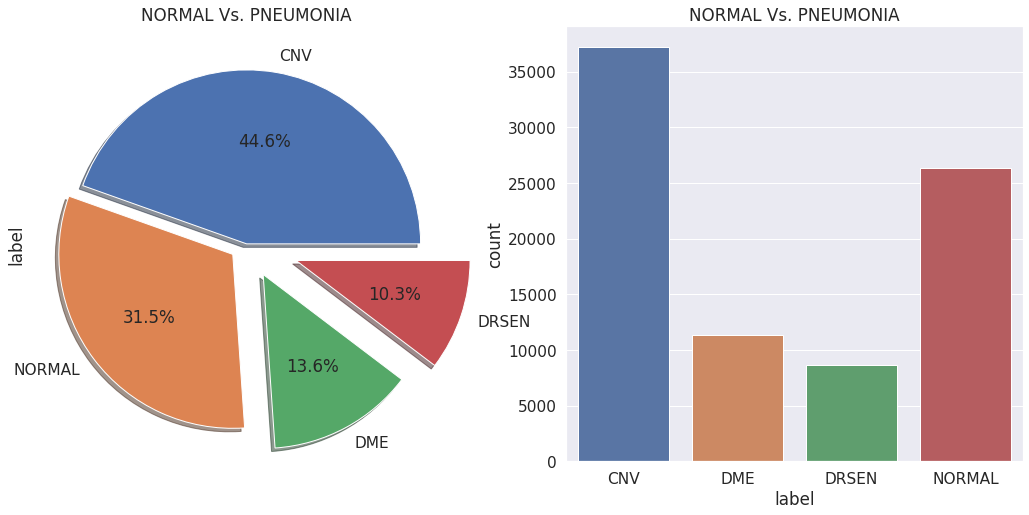

In [5]:
import seaborn as sns
f,ax=plt.subplots(1,2,figsize=(18,8))
path_label_df['label'].value_counts().plot.pie(explode=[0,0.1,0.2,0.3],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('NORMAL Vs. PNEUMONIA')
sns.countplot(x=path_label_df['label'])
ax[1].set_title('NORMAL Vs. PNEUMONIA')
plt.show()

In [6]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,
                                  
        rotation_range=10,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255)

In [6]:
pwd

'/workspace/data'

In [7]:
train_dataset  = train_datagen.flow_from_directory(directory = 'OCT_dgx/OCT2017/train',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 32)

Found 66788 images belonging to 4 classes.


In [8]:
test_dataset = test_datagen.flow_from_directory(directory = 'OCT_dgx/OCT2017/test',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  batch_size = 32)

Found 1004 images belonging to 4 classes.


In [9]:
# create an instance of VGG16 with pre-trained weights
IMAGE_SIZE = (224, 224)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
58892288/58889256 [==============================] - 3s 0us/step


In [10]:
# model = Model(inputs=resnet.input, outputs=prediction)
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
x = base_model.output
# x = GlobalAveragePooling2D()(x)
C3,C4,C5=base_model.output,base_model.output,base_model.output

# Top-down pathway

P5 = tf.keras.layers.Conv2D(512, (1, 1), strides=(1, 1), padding='valid', name='P6')(C5)
P4 = tf.keras.layers.Add(name='add_P4')([
    tf.keras.layers.UpSampling2D(size=(1, 1), name='upsample_P5')(P5),
    tf.keras.layers.Conv2D(512, (1, 1), strides=(1, 1), padding='valid', name='C4_reduced')(C4)
])
P4= tf.keras.layers.UpSampling2D(size=(1, 1), name='upsample_P4')(P4)
P3 = tf.keras.layers.Add(name='add_P3')([P4,
    tf.keras.layers.Conv2D(512, (1, 1), strides=(1, 1), padding='valid', name='C3_reduced')(C3)
])


x = Flatten()(P3)
x = Dense(units=1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(units=256, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(units=64, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(4, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

x = Flatten()(base_model.output)

In [ ]:
import tensorflow as tf

# Define the metrics including F1 score for 4-class classification
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.F1Score(name='f1_score', num_classes=4),
]


In [11]:
# freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

In [12]:
from tensorflow.keras.optimizers import Adam
# compile the model
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# model.compile(loss='binary_crossentropy',
# optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
# metrics='accuracy')

In [18]:
history=model.fit(train_dataset,
                        validation_data=test_dataset,validation_steps=8,
                        epochs = 10,verbose = 1)

Epoch 1/10
2088/2088 [==============================] - 932s 446ms/step - loss: 0.9306 - acc: 0.6453 - val_loss: 0.7535 - val_acc: 0.5898
Epoch 2/10
2088/2088 [==============================] - 935s 448ms/step - loss: 0.6363 - acc: 0.7797 - val_loss: 0.4710 - val_acc: 0.7266
Epoch 3/10
2088/2088 [==============================] - 940s 450ms/step - loss: 0.5640 - acc: 0.8042 - val_loss: 0.3815 - val_acc: 0.7852
Epoch 4/10
2088/2088 [==============================] - 937s 449ms/step - loss: 0.5208 - acc: 0.8188 - val_loss: 0.3457 - val_acc: 0.8789
Epoch 5/10
2088/2088 [==============================] - 941s 451ms/step - loss: 0.4884 - acc: 0.8302 - val_loss: 0.3423 - val_acc: 0.9258
Epoch 6/10
2088/2088 [==============================] - 943s 451ms/step - loss: 0.4706 - acc: 0.8380 - val_loss: 0.2739 - val_acc: 0.9258
Epoch 7/10
2088/2088 [==============================] - 944s 452ms/step - loss: 0.4550 - acc: 0.8426 - val_loss: 0.3035 - val_acc: 0.8828
Epoch 8/10
2088/2088 [============

In [21]:

import pandas as pd

df=pd.DataFrame(history.history)
df  

,loss,acc,val_loss,val_acc
0,0.930462,0.645311,0.753474,0.589844
1,0.636431,0.779676,0.470986,0.726562
2,0.564234,0.804171,0.381543,0.785156
3,0.520684,0.818830,0.345687,0.878906
4,0.488545,0.830164,0.342319,0.925781
5,0.470416,0.837965,0.273904,0.925781
6,0.455144,0.842577,0.303547,0.882812
7,0.440147,0.849674,0.239742,0.941406
8,0.427545,0.853552,0.247933,0.957031
9,0.421660,0.856426,0.276377,0.898438


In [25]:
df['acc'].max(),df['acc'].min()

(0.8564262986183167, 0.6453105211257935)

In [16]:
# df['val_accuracy'].max(),df['val_accuracy'].min()

In [26]:
df['loss'].max(),df['loss'].min()

(0.930461677597077, 0.42166008204337746)

In [23]:
preds = model.predict(test_dataset,verbose=1)

32/32 [==============================] - 3s 96ms/step


In [24]:
test_acc,loss = model.evaluate(test_dataset)

32/32 [==============================] - 3s 83ms/step - loss: 0.3049 - acc: 0.8853


In [13]:
history1=model.fit(train_dataset,
                        validation_data=test_dataset,validation_steps=8,
                        epochs = 100,verbose = 1)

Epoch 1/100
2088/2088 [==============================] - 940s 450ms/step - loss: 0.9347 - acc: 0.6456 - val_loss: 0.9372 - val_acc: 0.5000
Epoch 2/100
2088/2088 [==============================] - 926s 443ms/step - loss: 0.6524 - acc: 0.7708 - val_loss: 0.5597 - val_acc: 0.6836
Epoch 3/100
2088/2088 [==============================] - 930s 445ms/step - loss: 0.5663 - acc: 0.8038 - val_loss: 0.5349 - val_acc: 0.6602
Epoch 4/100
2088/2088 [==============================] - 924s 443ms/step - loss: 0.5168 - acc: 0.8190 - val_loss: 0.4020 - val_acc: 0.8438
Epoch 5/100
2088/2088 [==============================] - 929s 445ms/step - loss: 0.4927 - acc: 0.8289 - val_loss: 0.3630 - val_acc: 0.8711
Epoch 6/100
2088/2088 [==============================] - 926s 443ms/step - loss: 0.4711 - acc: 0.8377 - val_loss: 0.3600 - val_acc: 0.9023
Epoch 7/100
2088/2088 [==============================] - 926s 444ms/step - loss: 0.4553 - acc: 0.8448 - val_loss: 0.3430 - val_acc: 0.9023
Epoch 8/100
2088/2088 [====

In [15]:

import pandas as pd

df=pd.DataFrame(history1.history)
df  

,loss,acc,val_loss,val_acc
0,0.934563,0.645625,0.937180,0.500000
1,0.652426,0.770782,0.559690,0.683594
2,0.565773,0.803782,0.534925,0.660156
3,0.516890,0.819009,0.402035,0.843750
4,0.492883,0.828906,0.363032,0.871094
...,...,...,...,...
95,0.286646,0.903186,0.222095,0.929688
96,0.286332,0.903785,0.253381,0.890625
97,0.285656,0.901599,0.204012,0.910156
98,0.284645,0.904114,0.235754,0.914062


In [16]:
preds = model.predict(test_dataset,verbose=1)

32/32 [==============================] - 6s 176ms/step


In [17]:
test_acc,loss = model.evaluate(test_dataset)

32/32 [==============================] - 4s 112ms/step - loss: 0.2129 - acc: 0.9253


In [18]:
test_labels = test_dataset.classes


In [21]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(test_labels, np.argmax(preds, axis=1)) * 100
acc

27.88844621513944

In [24]:
# Compute confusion matrix
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(test_labels, predicted_labels)

NameError: name 'predicted_labels' is not defined

In [25]:
# Get the true labels from the test dataset
true_labels = test_dataset.classes

# Predict on the test dataset
preds = model.predict(test_dataset)

# Get class labels
class_labels = list(test_dataset.class_indices.keys())

# Generate a classification report
classification_rep = classification_report(true_labels, np.argmax(preds, axis=1), target_names=class_labels)

# Print the classification report
print(classification_rep)

              precision    recall  f1-score   support

         CNV       0.26      0.31      0.28       251
         DME       0.21      0.19      0.20       250
      DRUSEN       0.22      0.18      0.20       250
      NORMAL       0.25      0.27      0.26       253

    accuracy                           0.24      1004
   macro avg       0.23      0.24      0.23      1004
weighted avg       0.23      0.24      0.23      1004



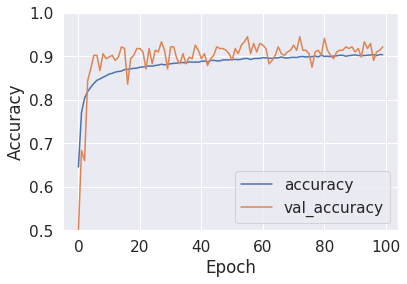

In [26]:
plt.plot(history1.history['acc'], label='accuracy')
plt.plot(history1.history['val_acc'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

# test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

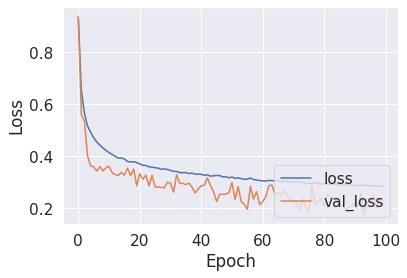

In [28]:
plt.plot(history1.history['loss'], label='loss')
plt.plot(history1.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.ylim([0.5, 1])
plt.legend(loc='lower right')

# test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [20]:
print(test_images.shape)

(280, 224, 224, 3)


<Axes: >

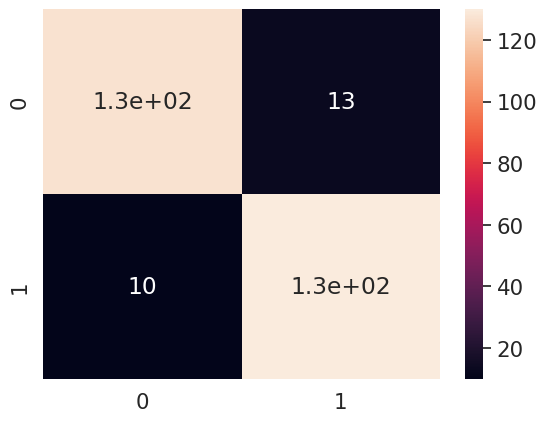

In [22]:
import seaborn as sns
sns.heatmap(cm, annot=True)